#Import libraries

In [1]:
import os
import urllib.request
from zipfile import ZipFile
import shutil 
from tqdm.notebook import tqdm
import gensim.downloader as gloader
import pandas as pd
import numpy as np
from itertools import chain
from natsort import natsorted
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, GRU, Embedding, TimeDistributed
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#Folders Creation

In [2]:
dataset_url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
dataset_folder = os.path.join(os.getcwd(), 'dataset')
print("Current work directory: " + str(dataset_folder))

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)


Current work directory: /content/dataset


#Download and Extract Dataset

In [3]:
dataset_path = os.path.join(dataset_folder, 'dependency_treebank.zip')
if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(dataset_url, dataset_path)

zipfile = ZipFile(dataset_path)
zipfile.extractall(dataset_folder)
zipfile.close()

#Split Data

In [4]:
sets=["train","val","test"]

for k in sets:
  if not os.path.exists(os.path.join("dataset",k)):
      os.makedirs(os.path.join("dataset",k))

files_folder = os.path.join(os.path.join(dataset_folder, "dependency_treebank"))


In [5]:
#from https://thispointer.com/python-get-list-of-files-in-directory-sorted-by-name/
filenames = sorted(filter(lambda x: os.path.isfile(os.path.join(files_folder, x)),os.listdir(files_folder) ) )

In [6]:
for i in range(0,len(filenames)):
  if i<100:
    dest= os.path.join(dataset_folder,sets[0])
  elif i<150:
    dest= os.path.join(dataset_folder,sets[1])
  else:
    dest=os.path.join(dataset_folder,sets[2])

  if not os.path.exists(os.path.join(dest, filenames[i])):
    shutil.move(os.path.join(files_folder, filenames[i]), dest)

#Load Data
Transform each set in a single file containing all the sentences

In [7]:
def load_files(files):
    output=[]
    for f in tqdm(natsorted(files)):
      with open(f, mode='r') as ff:
        w=[]
        t=[]
        for k in ff:
          splitted=k.split()
          if len(splitted) == 3:
              w.append(splitted[0].lower())
              t.append(splitted[1].lower())
          else:
            D={"Words":w,"Labels":t}
            output.append(D)
            w=[]
            t=[]
      if len(w) != 0:
        D={"Words":w,"Labels":t}
        output.append(D)
    return pd.DataFrame.from_dict(output)

In [8]:
train_files= [os.path.join("dataset","train",f) for f in os.listdir(os.path.join("dataset","train"))]
val_files=[os.path.join("dataset","val",f) for f in os.listdir(os.path.join("dataset","val"))]
test_files=[os.path.join("dataset","test",f) for f in os.listdir(os.path.join("dataset","test"))]
train_data=load_files(train_files)
val_data=load_files(val_files)
test_data=load_files(test_files)


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [9]:
train_data.head()

,Words,Labels
0,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[nnp, nnp, ,, cd, nns, jj, ,, md, vb, dt, nn, ..."
1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[nnp, nnp, vbz, nn, in, nnp, nnp, ,, dt, nnp, ..."
2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[nnp, nnp, ,, cd, nns, jj, cc, jj, nn, in, nnp..."
3,"[a, form, of, asbestos, once, used, to, make, ...","[dt, nn, in, nn, rb, vbn, to, vb, nnp, nn, nns..."
4,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[dt, nn, nn, ,, nn, ,, vbz, rb, jj, in, prp, v..."


In [10]:
print(train_data.shape)

(1963, 2)


#Embedding

In [11]:
EMBEDDING_DIMENSION="100"
print("Embedding dimension: "+EMBEDDING_DIMENSION)
embedding_model=gloader.load(f"glove-wiki-gigaword-{EMBEDDING_DIMENSION}")

Embedding dimension: 100
[==================================================] 100.0% 128.1/128.1MB downloaded


##Build vocabulary and embedding matrix

In [12]:
def build_vocabulary(train_set):
    l=[]
    for i in tqdm(set(train_data['Words'].sum())):
      l.append(i)
    vocabulary={}
    for k in range(0,len(l)):
      if l[k] not in vocabulary.values():
        vocabulary[k+1]=l[k]
    return vocabulary

voc=build_vocabulary(train_data)
print(voc)

oov1=set(voc.values()).difference(set(embedding_model.vocab.keys()))
print("The training set contains: "+str(len(oov1))+" oov words")

  0%|          | 0/7404 [00:00<?, ?it/s]

{1: 'eased', 2: 'should', 3: 'scenes', 4: 'standpoint', 5: 'flooded', 6: 'groucho', 7: 'candidate', 8: 'located', 9: 'leming', 10: 'strings', 11: 'navy', 12: 'cheerleading', 13: 'waiting', 14: 'plantation', 15: 'chile', 16: 'standard', 17: 'titans', 18: 'breaker', 19: 'kidnapping', 20: 'precise', 21: 'markey', 22: 'calif.', 23: 'rust', 24: 'careful', 25: 'onus', 26: '400,000', 27: 'economists', 28: 'twinned', 29: 'cigarettes', 30: 'country', 31: 'received', 32: 'roman', 33: 'administrators', 34: 'baker', 35: 'sen.', 36: 'u.s.', 37: 'spinoff', 38: 'quite', 39: 'executives', 40: 'bond', 41: 'stemming', 42: 'common', 43: 'grgich', 44: 'grapes', 45: 'friendship', 46: 'referring', 47: 'middle', 48: 'gates', 49: 'sacked', 50: '33', 51: 'nagymaros', 52: 'compiled', 53: 'headrests', 54: 'transaction', 55: 'presumably', 56: 'needham', 57: 'ready', 58: '500,004', 59: 'commerce', 60: 'addressing', 61: 'trucks', 62: 'concentrate', 63: 'edison', 64: 'christopher', 65: 'brokers', 66: 'governors', 67

In [13]:
#from tutorials
def build_embedding_matrix(embedding_model, voc):
  embedding_matrix = np.zeros((len(voc) + 1, embedding_model.vector_size), dtype = np.float32) 
  for idx, word in tqdm(voc.items()):
      try:
          embedding_vector = embedding_model[word]
      except (KeyError, TypeError):
          embedding_vector = np.random.uniform(-0.01,0.01,embedding_model.vector_size)
      embedding_matrix[idx] = embedding_vector
  return embedding_matrix

embedding_matrix=build_embedding_matrix(embedding_model,voc)
print(embedding_matrix.shape)

  0%|          | 0/7404 [00:00<?, ?it/s]

(7405, 100)


#Update vocabulary and embedding matrix for validation and test set

In [14]:
def update_voc(new_data,voc,embedding_model,embedding_matrix):
  ##finding oov
      known_words=set(embedding_model.vocab.keys()).union(set(voc.values()))
      oov = set(new_data['Words'].sum()).difference(set(known_words))
      print("Found other: "+str(len(list(oov)))+" oov words")

      #computing new vocabulary
      print(len(list(set(new_data['Words'].sum()))))
      new_words=set(new_data['Words'].sum()).difference(set(voc.values()))
      base=len(voc.keys())
      for i in tqdm(range(0,len(list(new_words)))):
        voc[base+i+1]=list(new_words)[i]
      if len(new_words) > 0:
        for k in tqdm(new_words):
          try:
            embedding_vector = embedding_model[k]
          except (KeyError, TypeError):
            embedding_vector = np.random.uniform(-0.01,0.01,embedding_model.vector_size)
          
          embedding_matrix = np.vstack((embedding_matrix, embedding_vector))
      print("Embedding matrix shape: " + str(embedding_matrix.shape))
      return embedding_matrix,voc


print("For validation set: \n")
embedding_matrix, voc = update_voc(val_data,voc,embedding_model,embedding_matrix)

print("For test set: \n")
embedding_matrix, voc = update_voc(test_data,voc,embedding_model,embedding_matrix)



For validation set: 

Found other: 189 oov words
5420


  0%|          | 0/2497 [00:00<?, ?it/s]

  0%|          | 0/2497 [00:00<?, ?it/s]

Embedding matrix shape: (9902, 100)
For test set: 

Found other: 128 oov words
3407


  0%|          | 0/1046 [00:00<?, ?it/s]

  0%|          | 0/1046 [00:00<?, ?it/s]

Embedding matrix shape: (10948, 100)


#Data preparation

In [15]:
def switch_voc(d):
  return dict([(value, key) for key, value in d.items()])
print(len(voc))
print(voc)
voc2=switch_voc(voc)
print(voc2)

10947
{1: 'eased', 2: 'should', 3: 'scenes', 4: 'standpoint', 5: 'flooded', 6: 'groucho', 7: 'candidate', 8: 'located', 9: 'leming', 10: 'strings', 11: 'navy', 12: 'cheerleading', 13: 'waiting', 14: 'plantation', 15: 'chile', 16: 'standard', 17: 'titans', 18: 'breaker', 19: 'kidnapping', 20: 'precise', 21: 'markey', 22: 'calif.', 23: 'rust', 24: 'careful', 25: 'onus', 26: '400,000', 27: 'economists', 28: 'twinned', 29: 'cigarettes', 30: 'country', 31: 'received', 32: 'roman', 33: 'administrators', 34: 'baker', 35: 'sen.', 36: 'u.s.', 37: 'spinoff', 38: 'quite', 39: 'executives', 40: 'bond', 41: 'stemming', 42: 'common', 43: 'grgich', 44: 'grapes', 45: 'friendship', 46: 'referring', 47: 'middle', 48: 'gates', 49: 'sacked', 50: '33', 51: 'nagymaros', 52: 'compiled', 53: 'headrests', 54: 'transaction', 55: 'presumably', 56: 'needham', 57: 'ready', 58: '500,004', 59: 'commerce', 60: 'addressing', 61: 'trucks', 62: 'concentrate', 63: 'edison', 64: 'christopher', 65: 'brokers', 66: 'governor

Change matrixes from words to ints

In [16]:
label_dict={}
labels=list(set(train_data['Labels'].sum()))
NUM_OF_LABELS = len(labels) + 1 
for i in range(NUM_OF_LABELS-1):
  label_dict[i+1]=labels[i]
label_dict2=switch_voc(label_dict)
print(label_dict2)
MAX_SEQ_LENGTH = max([len(k) for k in train_data['Words']])

{'-rrb-': 1, ',': 2, 'wrb': 3, 'in': 4, 'jjr': 5, 'nn': 6, 'vbp': 7, '$': 8, 'uh': 9, 'md': 10, 'wp': 11, 'nnp': 12, 'pos': 13, 'ex': 14, 'nnps': 15, 'vbn': 16, 'ls': 17, 'vbg': 18, 'vbd': 19, 'rbr': 20, 'vbz': 21, 'cc': 22, 'wdt': 23, 'vb': 24, 'sym': 25, 'prp': 26, ':': 27, 'wp$': 28, 'dt': 29, 'jj': 30, 'prp$': 31, 'cd': 32, 'to': 33, 'rbs': 34, 'nns': 35, 'fw': 36, 'rb': 37, "''": 38, '-lrb-': 39, '.': 40, '``': 41, '#': 42, 'pdt': 43, 'rp': 44, 'jjs': 45}


In [17]:
def prepare_matrix(sett):
  mat_words = [[voc2[sett['Words'][i][k]] for k in range(len(sett['Words'][i]))] for i in range(len(sett))] 
  mat_labels = [[label_dict2[sett['Labels'][i][k]] for k in range(len(sett['Labels'][i]))] for i in range(len(sett))] 

  mat_words =np.asarray([np.array(k) for k in mat_words],dtype=object)
  mat_labels =np.asarray([np.array(k) for k in mat_labels],dtype=object)

  mat_words = pad_sequences(mat_words, maxlen = MAX_SEQ_LENGTH, padding = 'post', truncating = 'post')
  mat_labels = pad_sequences(mat_labels, maxlen = MAX_SEQ_LENGTH, padding = 'post', truncating = 'post')
  return mat_words, mat_labels
  
train_mat_words, train_mat_labels=prepare_matrix(train_data)
val_mat_words, val_mat_labels=prepare_matrix(val_data)

#Model

##Baseline model

In [18]:
input_layer  = Input(shape = (MAX_SEQ_LENGTH, ))
embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = int(EMBEDDING_DIMENSION),
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(input_layer)

lstm_layer = Bidirectional(LSTM(16, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(embedding_layer)
dense_layer = TimeDistributed(Dense(NUM_OF_LABELS, activation = 'softmax'))(lstm_layer)
model1 = Model(input_layer, dense_layer)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
    
earlystop = [EarlyStopping(monitor = "val_loss", verbose = 1, patience = 3, mode = "auto")]

model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate=lr_schedule), metrics = ['acc'])
model1.summary()
model1.fit(train_mat_words, train_mat_labels, 
                   epochs = 30, callbacks = earlystop,
                   validation_data = (val_mat_words, val_mat_labels))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 249)]             0         
                                                                 
 embedding (Embedding)       (None, 249, 100)          1094800   
                                                                 
 bidirectional (Bidirectiona  (None, 249, 32)          14976     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 249, 46)          1518      
 ibuted)                                                         
                                                                 
Total params: 1,111,294
Trainable params: 16,494
Non-trainable params: 1,094,800
_________________________________________________________________
Epoch 1/30
62/62 [============================

##GRU

In [19]:
input_layer  = Input(shape = (MAX_SEQ_LENGTH, ))
embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = int(EMBEDDING_DIMENSION),
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(input_layer)

gru_layer = Bidirectional(GRU(16, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(embedding_layer)
dense_layer = TimeDistributed(Dense(NUM_OF_LABELS, activation = 'softmax'))(gru_layer)
model2 = Model(input_layer, dense_layer)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
    
earlystop = [EarlyStopping(monitor = "val_loss", verbose = 1, patience = 3, mode = "auto")]

model2.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(lr_schedule), metrics = ['acc'])
model2.summary()
model2.fit(train_mat_words, train_mat_labels, 
                   epochs = 30, callbacks = earlystop,
                   validation_data = (val_mat_words, val_mat_labels))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 249)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 249, 100)          1094800   
                                                                 
 bidirectional_1 (Bidirectio  (None, 249, 32)          11328     
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 249, 46)          1518      
 tributed)                                                       
                                                                 
Total params: 1,107,646
Trainable params: 12,846
Non-trainable params: 1,094,800
_________________________________________________________________
Epoch 1/30
62/62 [==========================

##Double LSTM

In [20]:
input_layer  = Input(shape = (MAX_SEQ_LENGTH, ))
embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = int(EMBEDDING_DIMENSION),
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(input_layer)

lstm_layer = Bidirectional(LSTM(16, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(embedding_layer)
lstm_layer2 = Bidirectional(LSTM(16, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(lstm_layer)
dense_layer = TimeDistributed(Dense(NUM_OF_LABELS, activation = 'softmax'))(lstm_layer2)
model3 = Model(input_layer, dense_layer)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
    
earlystop = [EarlyStopping(monitor = "val_loss", verbose = 1, patience = 3, mode = "auto")]

model3.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(lr_schedule), metrics = ['acc'])
model3.summary()
model3.fit(train_mat_words, train_mat_labels, 
                   epochs = 30, callbacks = earlystop,
                   validation_data = (val_mat_words, val_mat_labels))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 249)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 249, 100)          1094800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 249, 32)          14976     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 249, 32)          6272      
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 249, 46)          1518      
 tributed)                                                       
                                                           

##Double Dense

In [21]:
input_layer  = Input(shape = (MAX_SEQ_LENGTH, ))
embedding_layer = Embedding(input_dim = embedding_matrix.shape[0],
                            output_dim = int(EMBEDDING_DIMENSION),
                            mask_zero = True,
                            embeddings_initializer = Constant(embedding_matrix),
                            trainable = False)(input_layer)

lstm_layer = Bidirectional(LSTM(16, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.2))(embedding_layer)
dense_layer = TimeDistributed(Dense(NUM_OF_LABELS, activation = 'softmax'))(lstm_layer)
dense_layer2 = TimeDistributed(Dense(NUM_OF_LABELS, activation = 'softmax'))(dense_layer)
model4 = Model(input_layer, dense_layer2)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=100000,
    decay_rate=0.95,
    staircase=True)
    
earlystop = [EarlyStopping(monitor = "val_loss", verbose = 1, patience = 3, mode = "auto")]

model4.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(lr_schedule), metrics = ['acc'])
model4.summary()
model4.fit(train_mat_words, train_mat_labels, 
                   epochs = 30, callbacks = earlystop,
                   validation_data = (val_mat_words, val_mat_labels))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 249)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 249, 100)          1094800   
                                                                 
 bidirectional_4 (Bidirectio  (None, 249, 32)          14976     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 249, 46)          1518      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 249, 46)          2162      
 tributed)                                                       
                                                           

#Evaluation

Remove punctuation

In [22]:
print("Summary of evaluation on val data")
print("First model val loss, val acc:", model1.evaluate(val_mat_words, val_mat_labels, verbose=0))
print("Second model val loss, val acc:", model2.evaluate(val_mat_words, val_mat_labels, verbose=0))
print("Third model val loss, val acc:", model3.evaluate(val_mat_words, val_mat_labels, verbose=0))
print("Fourth model val loss, val acc:", model4.evaluate(val_mat_words, val_mat_labels, verbose=0))

#set the two best models
best1=model1
best2=model3
test_mat_words, test_mat_labels = prepare_matrix(test_data)

Summary of evaluation on val data
First model val loss, val acc: [0.027203481644392014, 0.9152743220329285]
Second model val loss, val acc: [0.029268736019730568, 0.907738208770752]
Third model val loss, val acc: [0.025233056396245956, 0.9229708313941956]
Fourth model val loss, val acc: [0.0863841325044632, 0.7498957514762878]


In [23]:
print(label_dict2)
punctuation_labels=[".", "$","-rrb-","-lrb-",",", "``", "''", "sym", "#", ":", "ls"]
punctuation_indexes=[k for t,k in label_dict2.items() if t in punctuation_labels]
interesting_indexes = list(set(range(1, NUM_OF_LABELS)).difference(set(punctuation_indexes)))
print(punctuation_indexes)
print(interesting_indexes)

{'-rrb-': 1, ',': 2, 'wrb': 3, 'in': 4, 'jjr': 5, 'nn': 6, 'vbp': 7, '$': 8, 'uh': 9, 'md': 10, 'wp': 11, 'nnp': 12, 'pos': 13, 'ex': 14, 'nnps': 15, 'vbn': 16, 'ls': 17, 'vbg': 18, 'vbd': 19, 'rbr': 20, 'vbz': 21, 'cc': 22, 'wdt': 23, 'vb': 24, 'sym': 25, 'prp': 26, ':': 27, 'wp$': 28, 'dt': 29, 'jj': 30, 'prp$': 31, 'cd': 32, 'to': 33, 'rbs': 34, 'nns': 35, 'fw': 36, 'rb': 37, "''": 38, '-lrb-': 39, '.': 40, '``': 41, '#': 42, 'pdt': 43, 'rp': 44, 'jjs': 45}
[1, 2, 8, 17, 25, 27, 38, 39, 40, 41, 42]
[3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 43, 44, 45]


In [24]:
def evaluate_model(model):
  test_pred = model.predict(test_mat_words) 
  test_pred = np.argmax(test_pred, axis = -1)
  return test_pred, f1_score(test_mat_labels.ravel(), test_pred.ravel(), average = "weighted", zero_division = 0, labels = interesting_indexes)

test_pred1, f1_score1 = evaluate_model(best1)
test_pred2, f1_score2 = evaluate_model(best2)
print(f'F1 score for the first model is {f1_score1}')
print(f'F1 score for the second model is {f1_score2}')

F1 score for the first model is 0.8203520744444723
F1 score for the second model is 0.9117712513301957


#Error Analysis

In [25]:
print(label_dict.keys())
a=list(set(test_mat_labels.ravel().tolist()))
a.remove(0)
print(a)

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 43, 44, 45]


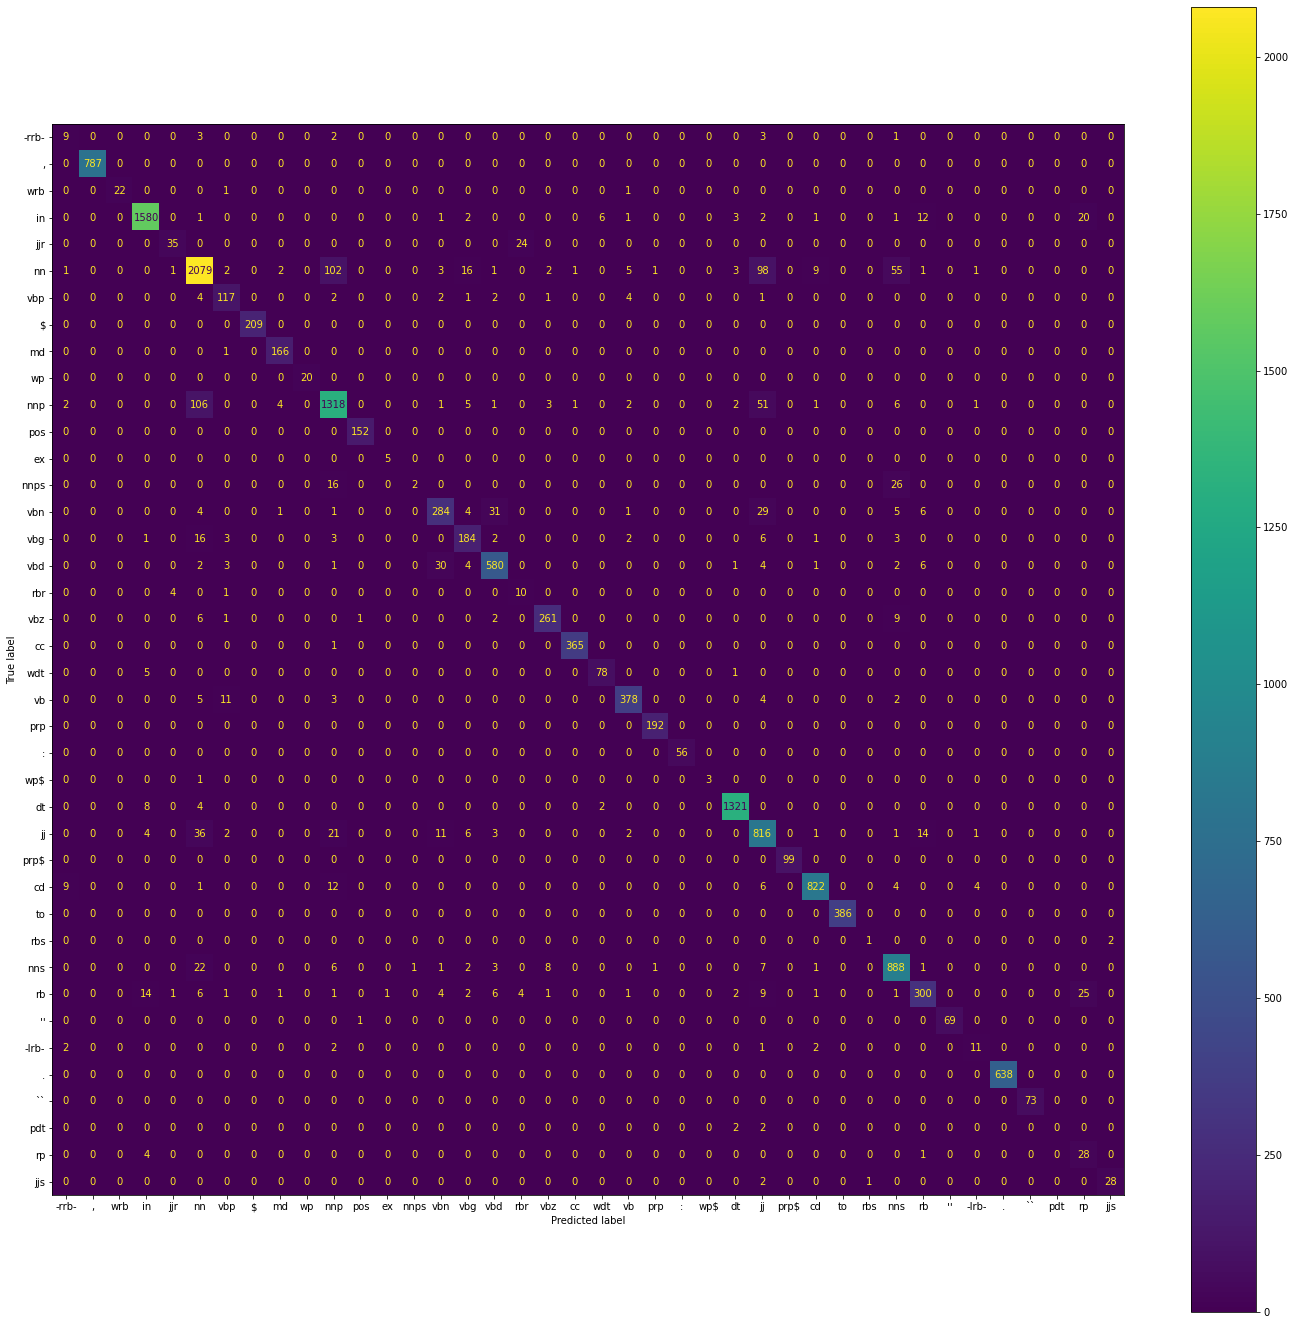

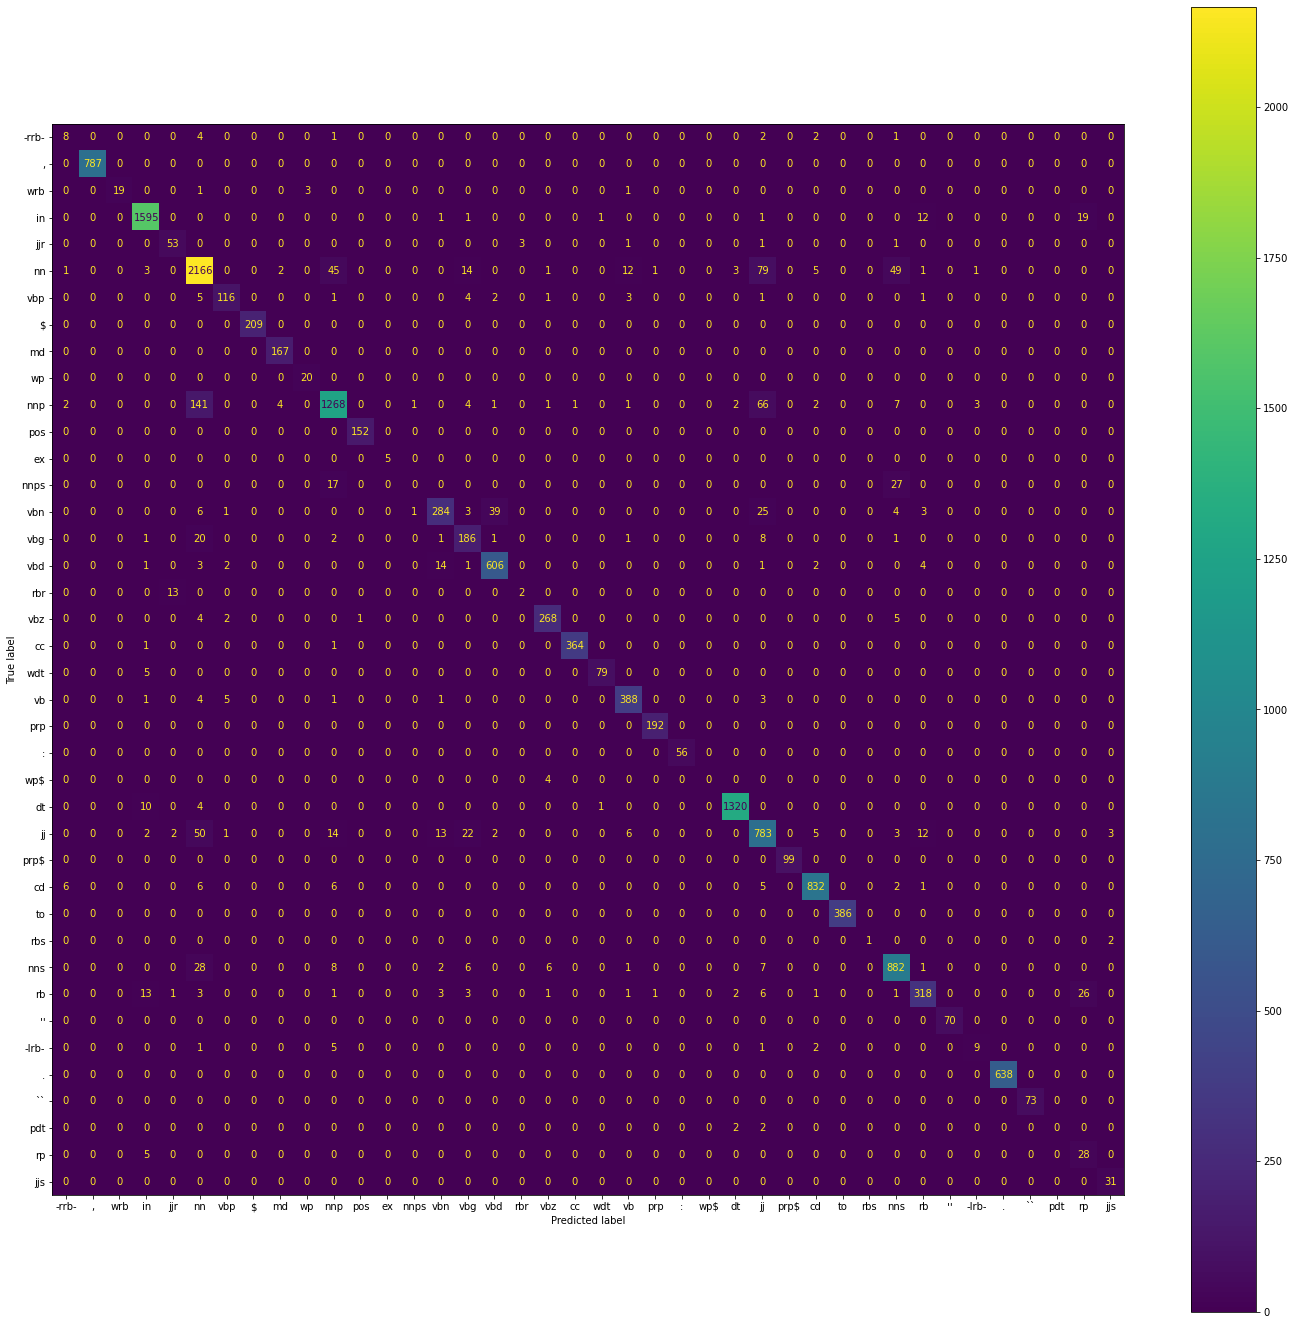

In [26]:
def plot_cm(true,pred):
  cm = confusion_matrix(true, pred)[1:,1:]
  cm = cm.astype('int') 
  cm = ConfusionMatrixDisplay(cm,display_labels=[label_dict[k] for k in a]) 
  fig, ax = plt.subplots(figsize=(24,24))
  cm.plot(include_values=True, ax=ax);
  plt.show()
plot_cm(test_mat_labels.ravel().tolist(), test_pred1.ravel().tolist())
plot_cm(test_mat_labels.ravel().tolist(), test_pred2.ravel().tolist())